In [1]:
import numpy as np
import pandas as pd

In [2]:
import pickle

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
#from matplotlib_venn import venn2, venn2_circles 
from tqdm import tqdm

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.svm import SVC

In [6]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif,SelectFromModel
from mrmr import mrmr_classif, mrmr_regression

In [7]:
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.metrics import classification_report,confusion_matrix

In [8]:
df = pd.read_csv('final_df.csv')

In [9]:
pd.set_option('display.max_columns', None)

In [10]:
df['is_canceled'].value_counts()

0    72476
1    42292
Name: is_canceled, dtype: int64

# Grid Search

In [79]:
df_test = df.sample(n = 10000, random_state=42)

In [80]:
X = df_test.iloc[:,1:]

In [81]:
y = df_test.iloc[:,0]

In [82]:
df_test

,is_canceled,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,hotel_Resort Hotel,meal_FB,meal_HB,meal_SC,meal_Undefined,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,market_segment_Undefined,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
1841,0,87,38,19,4,6,2,0.0,0,0,0,0,0,0,59.20,0,2,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
29066,0,158,44,29,2,5,2,0.0,0,0,0,0,0,0,37.14,0,2,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0
85764,0,105,21,16,1,3,2,0.0,0,0,0,0,0,0,119.85,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
80278,0,2,6,6,2,2,3,0.0,0,0,0,0,0,0,130.00,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0
7770,1,60,36,3,2,5,3,0.0,0,0,0,0,0,0,156.54,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11129,1,202,18,4,0,1,2,0.0,0,0,0,0,0,0,90.00,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
95923,0,377,42,14,0,2,2,0.0,0,0,0,0,0,0,115.00,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
91139,0,4,32,5,2,2,2,0.0,0,0,0,0,0,0,151.00,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
86870,0,15,23,30,2,5,2,0.0,0,0,0,0,0,0,115.84,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0


In [83]:
X_train, X_test, y_train,y_test = train_test_split(X, y, random_state = 42, stratify=y)

In [84]:
classifiers = [
    RandomForestClassifier(class_weight='balanced'),
    xgb.XGBClassifier(),
    SVC()]

In [85]:
scalers = [RobustScaler(),MinMaxScaler(),StandardScaler()]

In [86]:
lstresults = []
for scaler in tqdm(scalers):
    for classifier in tqdm(classifiers):
        pipe = Pipeline([
            ('scaler',scaler),
            ('feat_selection', SelectKBest(mutual_info_classif)),
            ('classifier', classifier)
        ])
        parameters = {
            'feat_selection__k':[i for i in range(15,30)]       
            }
        CV = GridSearchCV(pipe, parameters, 
                          scoring='f1_macro')
        CV.fit(X_train, y_train)
        a = classifier
        b = scaler
        c = CV.cv_results_['params']
        d = CV.cv_results_['mean_test_score']
        lstresults.append([a,b,c,d])

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [18:53<00:00, 377.68s/it]


In [87]:
lstresults

[[RandomForestClassifier(class_weight='balanced'),
  RobustScaler(),
  [{'feat_selection__k': 15},
   {'feat_selection__k': 16},
   {'feat_selection__k': 17},
   {'feat_selection__k': 18},
   {'feat_selection__k': 19},
   {'feat_selection__k': 20},
   {'feat_selection__k': 21},
   {'feat_selection__k': 22},
   {'feat_selection__k': 23},
   {'feat_selection__k': 24},
   {'feat_selection__k': 25},
   {'feat_selection__k': 26},
   {'feat_selection__k': 27},
   {'feat_selection__k': 28},
   {'feat_selection__k': 29}],
  array([0.77376237, 0.770863  , 0.77189195, 0.77688436, 0.78179793,
         0.78515214, 0.78466443, 0.79037564, 0.78572714, 0.79125636,
         0.78423563, 0.79642982, 0.79398931, 0.79075144, 0.79625272])],
 [XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feat

In [88]:
res = pd.DataFrame(lstresults)
res = res.explode([2,3])

In [89]:
res

,0,1,2,3
0,RandomForestClassifier(class_weight='balanced'),RobustScaler(),{'feat_selection__k': 15},0.773762
0,RandomForestClassifier(class_weight='balanced'),RobustScaler(),{'feat_selection__k': 16},0.770863
0,RandomForestClassifier(class_weight='balanced'),RobustScaler(),{'feat_selection__k': 17},0.771892
0,RandomForestClassifier(class_weight='balanced'),RobustScaler(),{'feat_selection__k': 18},0.776884
0,RandomForestClassifier(class_weight='balanced'),RobustScaler(),{'feat_selection__k': 19},0.781798
...,...,...,...,...
8,SVC(),StandardScaler(),{'feat_selection__k': 25},0.745779
8,SVC(),StandardScaler(),{'feat_selection__k': 26},0.752858
8,SVC(),StandardScaler(),{'feat_selection__k': 27},0.764929
8,SVC(),StandardScaler(),{'feat_selection__k': 28},0.756611


In [90]:
res.sort_values(3,ascending = False)

,0,1,2,3
0,RandomForestClassifier(class_weight='balanced'),RobustScaler(),{'feat_selection__k': 26},0.79643
0,RandomForestClassifier(class_weight='balanced'),RobustScaler(),{'feat_selection__k': 29},0.796253
3,RandomForestClassifier(class_weight='balanced'),MinMaxScaler(),{'feat_selection__k': 27},0.796124
6,RandomForestClassifier(class_weight='balanced'),StandardScaler(),{'feat_selection__k': 26},0.795811
0,RandomForestClassifier(class_weight='balanced'),RobustScaler(),{'feat_selection__k': 27},0.793989
...,...,...,...,...
2,SVC(),RobustScaler(),{'feat_selection__k': 25},0.685973
2,SVC(),RobustScaler(),{'feat_selection__k': 29},0.685928
2,SVC(),RobustScaler(),{'feat_selection__k': 20},0.684855
2,SVC(),RobustScaler(),{'feat_selection__k': 26},0.684828


In [91]:
pipe = Pipeline([
  ('scaler',RobustScaler()),
  ('feat_select', SelectKBest(mutual_info_classif,k=29)),
  ('classifier', RandomForestClassifier(random_state=42))
])

pipe.fit(X_train, y_train)
predictions = pipe.predict(X_test)
print(' - balanced accuracy:', round(balanced_accuracy_score(y_test, predictions),2))
print(' - macro f1:', round(f1_score(y_test, predictions, average='macro'),2))

 - balanced accuracy: 0.78
 - macro f1: 0.79


In [92]:
X_new = SelectKBest(score_func= mutual_info_classif, k=29).fit(X_train,y_train)

In [93]:
mask = X_new.get_support(indices=True)

In [94]:
mask

array([ 0,  1,  2,  3,  5,  6,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 23, 24, 25, 28, 29, 33, 34, 35, 39, 42, 43], dtype=int64)

In [95]:
lstcolumns = X_train.columns

In [96]:
dic = {i:lstcolumns[i] for i in range(len(lstcolumns))}

In [97]:
dic

{0: 'lead_time',
 1: 'arrival_date_week_number',
 2: 'arrival_date_day_of_month',
 3: 'stays_in_weekend_nights',
 4: 'stays_in_week_nights',
 5: 'adults',
 6: 'children',
 7: 'babies',
 8: 'is_repeated_guest',
 9: 'previous_cancellations',
 10: 'previous_bookings_not_canceled',
 11: 'booking_changes',
 12: 'days_in_waiting_list',
 13: 'adr',
 14: 'required_car_parking_spaces',
 15: 'total_of_special_requests',
 16: 'hotel_Resort Hotel',
 17: 'meal_FB',
 18: 'meal_HB',
 19: 'meal_SC',
 20: 'meal_Undefined',
 21: 'market_segment_Complementary',
 22: 'market_segment_Corporate',
 23: 'market_segment_Direct',
 24: 'market_segment_Groups',
 25: 'market_segment_Offline TA/TO',
 26: 'market_segment_Online TA',
 27: 'market_segment_Undefined',
 28: 'distribution_channel_GDS',
 29: 'distribution_channel_TA/TO',
 30: 'distribution_channel_Undefined',
 31: 'reserved_room_type_B',
 32: 'reserved_room_type_C',
 33: 'reserved_room_type_D',
 34: 'reserved_room_type_E',
 35: 'reserved_room_type_F',
 36

In [98]:
importantkbest = [dic[i] for i in list(mask)]

In [99]:
importantkbest

['lead_time',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'adults',
 'children',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'hotel_Resort Hotel',
 'meal_FB',
 'meal_HB',
 'meal_SC',
 'meal_Undefined',
 'market_segment_Direct',
 'market_segment_Groups',
 'market_segment_Offline TA/TO',
 'distribution_channel_GDS',
 'distribution_channel_TA/TO',
 'reserved_room_type_D',
 'reserved_room_type_E',
 'reserved_room_type_F',
 'deposit_type_Non Refund',
 'customer_type_Transient',
 'customer_type_Transient-Party']

In [100]:
importantkbest = list(X_train.columns)

# MRMR

In [101]:
df.columns

Index(['is_canceled', 'lead_time', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes',
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'hotel_Resort Hotel', 'meal_FB', 'meal_HB',
       'meal_SC', 'meal_Undefined', 'market_segment_Complementary',
       'market_segment_Corporate', 'market_segment_Direct',
       'market_segment_Groups', 'market_segment_Offline TA/TO',
       'market_segment_Online TA', 'market_segment_Undefined',
       'distribution_channel_GDS', 'distribution_channel_TA/TO',
       'distribution_channel_Undefined', 'reserved_room_type_B',
       'reserved_room_type_C', 'reserved_room_type_D', 'reserved_room_type_E',
       'reserved_room_type_F', 'reserved_room_type_G', 'reserved_room_type_H',
     

In [102]:
classifiers = [
    RandomForestClassifier(class_weight='balanced'),
    xgb.XGBClassifier(),
    SVC()]

In [103]:
results = []
for classifier in classifiers:
    clas = classifier
    for i in range(5,30):
        lst = (mrmr_classif(X_train,y_train.values,K=i))
        print(lst)
        X_train_temp = X_train.loc[:,lst]
        X_test_temp = X_test.loc[:,lst]
        clas.fit(X_train_temp, y_train)
        y_pred = classifier.predict(X_test_temp)
        a = len(lst)
        b = lst
        c = str(classifier)
        d = balanced_accuracy_score(y_test, y_pred)
        e = f1_score(y_test, y_pred, average='macro')
        results.append([a,b,c,d,e])

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes']


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 29.28it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct']


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 26.19it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups']


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 26.89it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel']


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 24.01it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations']


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.46it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO']


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 23.57it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient']


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 24.66it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient', 'customer_type_Transient-Party']


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 23.04it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient', 'customer_type_Transient-Party', 'is_repeated_guest']


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.97it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient', 'customer_type_Transient-Party', 'is_repeated_guest', 'days_in_waiting_list']


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 17.99it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient', 'customer_type_Transient-Party', 'is_repeated_guest', 'days_in_waiting_list', 'customer_type_Group']


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 23.29it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient', 'customer_type_Transient-Party', 'is_repeated_guest', 'days_in_waiting_list', 'customer_type_Group', 'previous_bookings_not_canceled']


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 23.74it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient', 'customer_type_Transient-Party', 'is_repeated_guest', 'days_in_waiting_list', 'customer_type_Group', 'previous_bookings_not_canceled', 'reserved_room_type_E']


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 23.58it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient', 'customer_type_Transient-Party', 'is_repeated_guest', 'days_in_waiting_list', 'customer_type_Group', 'previous_bookings_not_canceled', 'reserved_room_type_E', 'market_segment_Corporate']


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 24.51it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient', 'customer_type_Transient-Party', 'is_repeated_guest', 'days_in_waiting_list', 'customer_type_Group', 'previous_bookings_not_canceled', 'reserved_room_type_E', 'market_segment_Corporate', 'reserved_room_type_F']


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 22.78it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient', 'customer_type_Transient-Party', 'is_repeated_guest', 'days_in_waiting_list', 'customer_type_Group', 'previous_bookings_not_canceled', 'reserved_room_type_E', 'market_segment_Corporate', 'reserved_room_type_F', 'reserved_room_type_D']


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 21.47it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient', 'customer_type_Transient-Party', 'is_repeated_guest', 'days_in_waiting_list', 'customer_type_Group', 'previous_bookings_not_canceled', 'reserved_room_type_E', 'market_segment_Corporate', 'reserved_room_type_F', 'reserved_room_type_D', 'market_segment_Undefined']


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 24.23it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient', 'customer_type_Transient-Party', 'is_repeated_guest', 'days_in_waiting_list', 'customer_type_Group', 'previous_bookings_not_canceled', 'reserved_room_type_E', 'market_segment_Corporate', 'reserved_room_type_F', 'reserved_room_type_D', 'market_segment_Undefined', 'meal_FB']


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 27.92it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient', 'customer_type_Transient-Party', 'is_repeated_guest', 'days_in_waiting_list', 'customer_type_Group', 'previous_bookings_not_canceled', 'reserved_room_type_E', 'market_segment_Corporate', 'reserved_room_type_F', 'reserved_room_type_D', 'market_segment_Undefined', 'meal_FB', 'adults']


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 26.05it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient', 'customer_type_Transient-Party', 'is_repeated_guest', 'days_in_waiting_list', 'customer_type_Group', 'previous_bookings_not_canceled', 'reserved_room_type_E', 'market_segment_Corporate', 'reserved_room_type_F', 'reserved_room_type_D', 'market_segment_Undefined', 'meal_FB', 'adults', 'babies']


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 20.58it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient', 'customer_type_Transient-Party', 'is_repeated_guest', 'days_in_waiting_list', 'customer_type_Group', 'previous_bookings_not_canceled', 'reserved_room_type_E', 'market_segment_Corporate', 'reserved_room_type_F', 'reserved_room_type_D', 'market_segment_Undefined', 'meal_FB', 'adults', 'babies', 'market_segment_Complementary']


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 22.75it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient', 'customer_type_Transient-Party', 'is_repeated_guest', 'days_in_waiting_list', 'customer_type_Group', 'previous_bookings_not_canceled', 'reserved_room_type_E', 'market_segment_Corporate', 'reserved_room_type_F', 'reserved_room_type_D', 'market_segment_Undefined', 'meal_FB', 'adults', 'babies', 'market_segment_Complementary', 'reserved_room_type_B']


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 23.69it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient', 'customer_type_Transient-Party', 'is_repeated_guest', 'days_in_waiting_list', 'customer_type_Group', 'previous_bookings_not_canceled', 'reserved_room_type_E', 'market_segment_Corporate', 'reserved_room_type_F', 'reserved_room_type_D', 'market_segment_Undefined', 'meal_FB', 'adults', 'babies', 'market_segment_Complementary', 'reserved_room_type_B', 'adr']


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 24.96it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient', 'customer_type_Transient-Party', 'is_repeated_guest', 'days_in_waiting_list', 'customer_type_Group', 'previous_bookings_not_canceled', 'reserved_room_type_E', 'market_segment_Corporate', 'reserved_room_type_F', 'reserved_room_type_D', 'market_segment_Undefined', 'meal_FB', 'adults', 'babies', 'market_segment_Complementary', 'reserved_room_type_B', 'adr', 'reserved_room_type_L']


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 22.52it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient', 'customer_type_Transient-Party', 'is_repeated_guest', 'days_in_waiting_list', 'customer_type_Group', 'previous_bookings_not_canceled', 'reserved_room_type_E', 'market_segment_Corporate', 'reserved_room_type_F', 'reserved_room_type_D', 'market_segment_Undefined', 'meal_FB', 'adults', 'babies', 'market_segment_Complementary', 'reserved_room_type_B', 'adr', 'reserved_room_type_L', 'arrival_date_week_number']


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.76it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes']


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 24.15it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct']


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 24.76it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups']


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 24.29it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel']


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 24.19it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations']


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 22.88it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO']


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 22.98it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient']


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 22.89it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient', 'customer_type_Transient-Party']


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 26.17it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient', 'customer_type_Transient-Party', 'is_repeated_guest']


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 24.28it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient', 'customer_type_Transient-Party', 'is_repeated_guest', 'days_in_waiting_list']


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 21.24it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient', 'customer_type_Transient-Party', 'is_repeated_guest', 'days_in_waiting_list', 'customer_type_Group']


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 21.37it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient', 'customer_type_Transient-Party', 'is_repeated_guest', 'days_in_waiting_list', 'customer_type_Group', 'previous_bookings_not_canceled']


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 24.48it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient', 'customer_type_Transient-Party', 'is_repeated_guest', 'days_in_waiting_list', 'customer_type_Group', 'previous_bookings_not_canceled', 'reserved_room_type_E']


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 21.17it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient', 'customer_type_Transient-Party', 'is_repeated_guest', 'days_in_waiting_list', 'customer_type_Group', 'previous_bookings_not_canceled', 'reserved_room_type_E', 'market_segment_Corporate']


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 25.08it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient', 'customer_type_Transient-Party', 'is_repeated_guest', 'days_in_waiting_list', 'customer_type_Group', 'previous_bookings_not_canceled', 'reserved_room_type_E', 'market_segment_Corporate', 'reserved_room_type_F']


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 25.32it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient', 'customer_type_Transient-Party', 'is_repeated_guest', 'days_in_waiting_list', 'customer_type_Group', 'previous_bookings_not_canceled', 'reserved_room_type_E', 'market_segment_Corporate', 'reserved_room_type_F', 'reserved_room_type_D']


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 23.31it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient', 'customer_type_Transient-Party', 'is_repeated_guest', 'days_in_waiting_list', 'customer_type_Group', 'previous_bookings_not_canceled', 'reserved_room_type_E', 'market_segment_Corporate', 'reserved_room_type_F', 'reserved_room_type_D', 'market_segment_Undefined']


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 22.49it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient', 'customer_type_Transient-Party', 'is_repeated_guest', 'days_in_waiting_list', 'customer_type_Group', 'previous_bookings_not_canceled', 'reserved_room_type_E', 'market_segment_Corporate', 'reserved_room_type_F', 'reserved_room_type_D', 'market_segment_Undefined', 'meal_FB']


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 21.73it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient', 'customer_type_Transient-Party', 'is_repeated_guest', 'days_in_waiting_list', 'customer_type_Group', 'previous_bookings_not_canceled', 'reserved_room_type_E', 'market_segment_Corporate', 'reserved_room_type_F', 'reserved_room_type_D', 'market_segment_Undefined', 'meal_FB', 'adults']


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 22.08it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient', 'customer_type_Transient-Party', 'is_repeated_guest', 'days_in_waiting_list', 'customer_type_Group', 'previous_bookings_not_canceled', 'reserved_room_type_E', 'market_segment_Corporate', 'reserved_room_type_F', 'reserved_room_type_D', 'market_segment_Undefined', 'meal_FB', 'adults', 'babies']


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 18.73it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient', 'customer_type_Transient-Party', 'is_repeated_guest', 'days_in_waiting_list', 'customer_type_Group', 'previous_bookings_not_canceled', 'reserved_room_type_E', 'market_segment_Corporate', 'reserved_room_type_F', 'reserved_room_type_D', 'market_segment_Undefined', 'meal_FB', 'adults', 'babies', 'market_segment_Complementary']


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 22.10it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient', 'customer_type_Transient-Party', 'is_repeated_guest', 'days_in_waiting_list', 'customer_type_Group', 'previous_bookings_not_canceled', 'reserved_room_type_E', 'market_segment_Corporate', 'reserved_room_type_F', 'reserved_room_type_D', 'market_segment_Undefined', 'meal_FB', 'adults', 'babies', 'market_segment_Complementary', 'reserved_room_type_B']


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 22.39it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient', 'customer_type_Transient-Party', 'is_repeated_guest', 'days_in_waiting_list', 'customer_type_Group', 'previous_bookings_not_canceled', 'reserved_room_type_E', 'market_segment_Corporate', 'reserved_room_type_F', 'reserved_room_type_D', 'market_segment_Undefined', 'meal_FB', 'adults', 'babies', 'market_segment_Complementary', 'reserved_room_type_B', 'adr']


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 22.86it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient', 'customer_type_Transient-Party', 'is_repeated_guest', 'days_in_waiting_list', 'customer_type_Group', 'previous_bookings_not_canceled', 'reserved_room_type_E', 'market_segment_Corporate', 'reserved_room_type_F', 'reserved_room_type_D', 'market_segment_Undefined', 'meal_FB', 'adults', 'babies', 'market_segment_Complementary', 'reserved_room_type_B', 'adr', 'reserved_room_type_L']


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 21.96it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient', 'customer_type_Transient-Party', 'is_repeated_guest', 'days_in_waiting_list', 'customer_type_Group', 'previous_bookings_not_canceled', 'reserved_room_type_E', 'market_segment_Corporate', 'reserved_room_type_F', 'reserved_room_type_D', 'market_segment_Undefined', 'meal_FB', 'adults', 'babies', 'market_segment_Complementary', 'reserved_room_type_B', 'adr', 'reserved_room_type_L', 'arrival_date_week_number']


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.02it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes']


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 25.36it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct']


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 28.13it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups']


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 30.27it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel']


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 28.94it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations']


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.89it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO']


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 27.03it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient']


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 27.26it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient', 'customer_type_Transient-Party']


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 23.76it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient', 'customer_type_Transient-Party', 'is_repeated_guest']


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 28.81it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient', 'customer_type_Transient-Party', 'is_repeated_guest', 'days_in_waiting_list']


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 22.76it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient', 'customer_type_Transient-Party', 'is_repeated_guest', 'days_in_waiting_list', 'customer_type_Group']


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.54it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient', 'customer_type_Transient-Party', 'is_repeated_guest', 'days_in_waiting_list', 'customer_type_Group', 'previous_bookings_not_canceled']


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 26.55it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient', 'customer_type_Transient-Party', 'is_repeated_guest', 'days_in_waiting_list', 'customer_type_Group', 'previous_bookings_not_canceled', 'reserved_room_type_E']


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 28.10it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient', 'customer_type_Transient-Party', 'is_repeated_guest', 'days_in_waiting_list', 'customer_type_Group', 'previous_bookings_not_canceled', 'reserved_room_type_E', 'market_segment_Corporate']


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 26.39it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient', 'customer_type_Transient-Party', 'is_repeated_guest', 'days_in_waiting_list', 'customer_type_Group', 'previous_bookings_not_canceled', 'reserved_room_type_E', 'market_segment_Corporate', 'reserved_room_type_F']


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 22.47it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient', 'customer_type_Transient-Party', 'is_repeated_guest', 'days_in_waiting_list', 'customer_type_Group', 'previous_bookings_not_canceled', 'reserved_room_type_E', 'market_segment_Corporate', 'reserved_room_type_F', 'reserved_room_type_D']


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 22.72it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient', 'customer_type_Transient-Party', 'is_repeated_guest', 'days_in_waiting_list', 'customer_type_Group', 'previous_bookings_not_canceled', 'reserved_room_type_E', 'market_segment_Corporate', 'reserved_room_type_F', 'reserved_room_type_D', 'market_segment_Undefined']


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 19.17it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient', 'customer_type_Transient-Party', 'is_repeated_guest', 'days_in_waiting_list', 'customer_type_Group', 'previous_bookings_not_canceled', 'reserved_room_type_E', 'market_segment_Corporate', 'reserved_room_type_F', 'reserved_room_type_D', 'market_segment_Undefined', 'meal_FB']


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 22.37it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient', 'customer_type_Transient-Party', 'is_repeated_guest', 'days_in_waiting_list', 'customer_type_Group', 'previous_bookings_not_canceled', 'reserved_room_type_E', 'market_segment_Corporate', 'reserved_room_type_F', 'reserved_room_type_D', 'market_segment_Undefined', 'meal_FB', 'adults']


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 22.35it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient', 'customer_type_Transient-Party', 'is_repeated_guest', 'days_in_waiting_list', 'customer_type_Group', 'previous_bookings_not_canceled', 'reserved_room_type_E', 'market_segment_Corporate', 'reserved_room_type_F', 'reserved_room_type_D', 'market_segment_Undefined', 'meal_FB', 'adults', 'babies']


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 23.75it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient', 'customer_type_Transient-Party', 'is_repeated_guest', 'days_in_waiting_list', 'customer_type_Group', 'previous_bookings_not_canceled', 'reserved_room_type_E', 'market_segment_Corporate', 'reserved_room_type_F', 'reserved_room_type_D', 'market_segment_Undefined', 'meal_FB', 'adults', 'babies', 'market_segment_Complementary']


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 24.53it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient', 'customer_type_Transient-Party', 'is_repeated_guest', 'days_in_waiting_list', 'customer_type_Group', 'previous_bookings_not_canceled', 'reserved_room_type_E', 'market_segment_Corporate', 'reserved_room_type_F', 'reserved_room_type_D', 'market_segment_Undefined', 'meal_FB', 'adults', 'babies', 'market_segment_Complementary', 'reserved_room_type_B']


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 23.28it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient', 'customer_type_Transient-Party', 'is_repeated_guest', 'days_in_waiting_list', 'customer_type_Group', 'previous_bookings_not_canceled', 'reserved_room_type_E', 'market_segment_Corporate', 'reserved_room_type_F', 'reserved_room_type_D', 'market_segment_Undefined', 'meal_FB', 'adults', 'babies', 'market_segment_Complementary', 'reserved_room_type_B', 'adr']


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 21.12it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient', 'customer_type_Transient-Party', 'is_repeated_guest', 'days_in_waiting_list', 'customer_type_Group', 'previous_bookings_not_canceled', 'reserved_room_type_E', 'market_segment_Corporate', 'reserved_room_type_F', 'reserved_room_type_D', 'market_segment_Undefined', 'meal_FB', 'adults', 'babies', 'market_segment_Complementary', 'reserved_room_type_B', 'adr', 'reserved_room_type_L']


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 25.44it/s]


['deposit_type_Non Refund', 'required_car_parking_spaces', 'lead_time', 'total_of_special_requests', 'booking_changes', 'market_segment_Direct', 'market_segment_Groups', 'hotel_Resort Hotel', 'previous_cancellations', 'distribution_channel_TA/TO', 'customer_type_Transient', 'customer_type_Transient-Party', 'is_repeated_guest', 'days_in_waiting_list', 'customer_type_Group', 'previous_bookings_not_canceled', 'reserved_room_type_E', 'market_segment_Corporate', 'reserved_room_type_F', 'reserved_room_type_D', 'market_segment_Undefined', 'meal_FB', 'adults', 'babies', 'market_segment_Complementary', 'reserved_room_type_B', 'adr', 'reserved_room_type_L', 'arrival_date_week_number']


In [104]:
res = pd.DataFrame(results)

In [105]:
res

,0,1,2,3,4
0,5,"[deposit_type_Non Refund, required_car_parking...",RandomForestClassifier(class_weight='balanced'),0.696187,0.694159
1,6,"[deposit_type_Non Refund, required_car_parking...",RandomForestClassifier(class_weight='balanced'),0.691343,0.689772
2,7,"[deposit_type_Non Refund, required_car_parking...",RandomForestClassifier(class_weight='balanced'),0.696510,0.696118
3,8,"[deposit_type_Non Refund, required_car_parking...",RandomForestClassifier(class_weight='balanced'),0.704589,0.705079
4,9,"[deposit_type_Non Refund, required_car_parking...",RandomForestClassifier(class_weight='balanced'),0.713327,0.714476
...,...,...,...,...,...
70,25,"[deposit_type_Non Refund, required_car_parking...",SVC(),0.575492,0.556064
71,26,"[deposit_type_Non Refund, required_car_parking...",SVC(),0.575492,0.556064
72,27,"[deposit_type_Non Refund, required_car_parking...",SVC(),0.574682,0.556574
73,28,"[deposit_type_Non Refund, required_car_parking...",SVC(),0.574682,0.556574


In [106]:
res.sort_values(4,ascending = False)

,0,1,2,3,4
24,29,"[deposit_type_Non Refund, required_car_parking...",RandomForestClassifier(class_weight='balanced'),0.775019,0.786141
23,28,"[deposit_type_Non Refund, required_car_parking...",RandomForestClassifier(class_weight='balanced'),0.773226,0.781888
22,27,"[deposit_type_Non Refund, required_car_parking...",RandomForestClassifier(class_weight='balanced'),0.770877,0.779342
49,29,"[deposit_type_Non Refund, required_car_parking...","XGBClassifier(base_score=None, booster=None, c...",0.768214,0.778186
48,28,"[deposit_type_Non Refund, required_car_parking...","XGBClassifier(base_score=None, booster=None, c...",0.764545,0.774820
...,...,...,...,...,...
53,8,"[deposit_type_Non Refund, required_car_parking...",SVC(),0.564526,0.544617
51,6,"[deposit_type_Non Refund, required_car_parking...",SVC(),0.564208,0.544326
56,11,"[deposit_type_Non Refund, required_car_parking...",SVC(),0.564405,0.543979
55,10,"[deposit_type_Non Refund, required_car_parking...",SVC(),0.563548,0.542930


In [107]:
importantmrmr = res.iloc[23,1]

In [108]:
importantmrmr

['deposit_type_Non Refund',
 'required_car_parking_spaces',
 'lead_time',
 'total_of_special_requests',
 'booking_changes',
 'market_segment_Direct',
 'market_segment_Groups',
 'hotel_Resort Hotel',
 'previous_cancellations',
 'distribution_channel_TA/TO',
 'customer_type_Transient',
 'customer_type_Transient-Party',
 'is_repeated_guest',
 'days_in_waiting_list',
 'customer_type_Group',
 'previous_bookings_not_canceled',
 'reserved_room_type_E',
 'market_segment_Corporate',
 'reserved_room_type_F',
 'reserved_room_type_D',
 'market_segment_Undefined',
 'meal_FB',
 'adults',
 'babies',
 'market_segment_Complementary',
 'reserved_room_type_B',
 'adr',
 'reserved_room_type_L']

In [109]:
importantkbest

['lead_time',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'hotel_Resort Hotel',
 'meal_FB',
 'meal_HB',
 'meal_SC',
 'meal_Undefined',
 'market_segment_Complementary',
 'market_segment_Corporate',
 'market_segment_Direct',
 'market_segment_Groups',
 'market_segment_Offline TA/TO',
 'market_segment_Online TA',
 'market_segment_Undefined',
 'distribution_channel_GDS',
 'distribution_channel_TA/TO',
 'distribution_channel_Undefined',
 'reserved_room_type_B',
 'reserved_room_type_C',
 'reserved_room_type_D',
 'reserved_room_type_E',
 'reserved_room_type_F',
 'reserved_room_type_G',
 'reserved_room_type_H',
 'reserved_room_type_L',
 'deposit_type_Non Refund',
 'deposit_type_Refundable',
 'cust

In [110]:
set2 = set(importantmrmr) & set(importantkbest)

In [75]:
venn2(subsets=(len(importantmrmr), len(importantkbest), len(set2)),  
      set_labels=('MRMR Important', 'Select K Best Important'), 
      set_colors=("orange", "blue"), alpha=0.7) 
  
# add outline 
venn2_circles(subsets=(len(importantmrmr), len(importantkbest), len(set2)),  
              linestyle="dashed",  
              linewidth=2) 
  
# assign title of the venn diagram 
plt.title("Venn Diagram in Feature Importance")   
plt.show() 

NameError: name 'venn2' is not defined

In [111]:
finalmodel = Pipeline([
  ('scaler',RobustScaler()),
  ('feat_select', SelectKBest(mutual_info_classif,k=29)),
  ('classifier', RandomForestClassifier(random_state=42))
])

finalmodel.fit(X_train, y_train)
predictions = finalmodel.predict(X_test)
print(' - balanced accuracy:', round(balanced_accuracy_score(y_test, predictions),2))
print(' - macro f1:', round(f1_score(y_test, predictions, average='macro'),2))

 - balanced accuracy: 0.79
 - macro f1: 0.8


In [112]:
cnf_matrix = confusion_matrix(predictions, y_test)
cnf_matrix

array([[1435,  310],
       [ 136,  619]], dtype=int64)

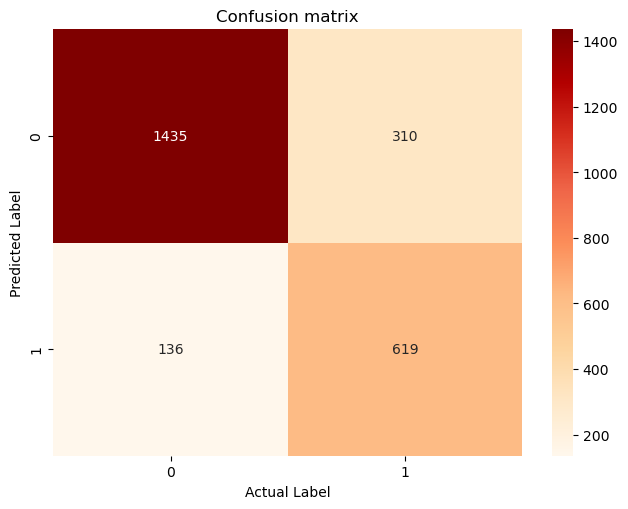

In [113]:
class_names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks,class_names)
plt.yticks(tick_marks,class_names)

#Create Heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot= True, cmap = "OrRd", fmt ="g")
plt.tight_layout()
plt.title("Confusion matrix")
plt.xlabel("Actual Label")
plt.ylabel("Predicted Label")
None